# Experiment 2: Rate of performance comparison

**Environment Setup**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.feature_extraction.text import CountVectorizer
!pip install spacy
!pip install xgboost
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
import functions
import experiment_2_functions
from sklearn.metrics import f1_score
pd.set_option('mode.chained_assignment', None)


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [40]:
#Load cleaned raw bank transaction dataset
df = pd.read_csv(r'df_postfeat_time_series_FINAL.csv',low_memory=False,encoding='latin1')

In [8]:
#External resources
stopwords = pd.read_csv(r'stopwords.csv',low_memory=False,encoding='latin1')
abb = pd.read_csv(r'normalisation.csv',low_memory=False,encoding='latin1')

## 1. Rule-based system

In [41]:
local_labelled = df[df['standard_transaction_type_id']!=-1]
count=local_labelled['standard_transaction_type_id'].groupby(local_labelled['local_rule_creation_date']).count()
count=count.to_frame().reset_index()
y = count['standard_transaction_type_id'].cumsum()

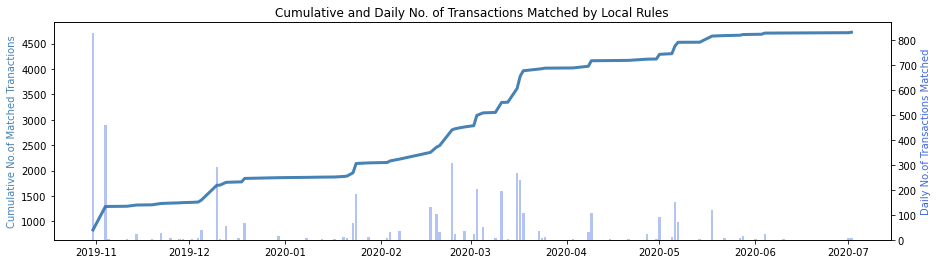

In [33]:
fig, time_series_monthly_1 = plt.subplots(figsize=(15,5))
count.local_rule_creation_date = pd.to_datetime(count.local_rule_creation_date)
time_series_monthly_2 = time_series_monthly_1.twinx()

#Plot line graphs
time_series_monthly_1.plot(count['local_rule_creation_date'], y, color='steelblue',linewidth=3)
time_series_monthly_2.bar(count['local_rule_creation_date'], count['standard_transaction_type_id'], color='royalblue', alpha = 0.4,label = 'Number of Rules Matched Daily')

#Format plot
time_series_monthly_1.set_ylabel('Cumulative No.of Matched Tranactions', color='steelblue')
time_series_monthly_2.set_ylabel('Daily No.of Transactions Matched', color='royalblue')
plt.title("Cumulative and Daily No. of Transactions Matched by Local Rules")
plt.xlabel("Month")
plt.show()

 ## 2. Machine Learning: Baseline Approach

In [5]:
#Load training and testing sets in baseline approach
Train_baseline = pd.read_csv(r'Train_trad.csv',low_memory=False,encoding='latin1')
Test_baseline = pd.read_csv(r'Test_trad.csv',low_memory=False,encoding='latin1')

In [6]:
#Prepare for final datasets
Train_baseline.index = Train_baseline['Unnamed: 0'].values
Train_baseline = functions.drop_column(Train_baseline,'Unnamed: 0')
Test_baseline.index = Test_baseline['Unnamed: 0'].values
Test_baseline = functions.drop_column(Test_baseline,'Unnamed: 0')

In [7]:
#Final model in baseline approach, based on the conclusion found in experiment 1
finalmodel = MLPClassifier(activation= 'relu',alpha= 0.05,hidden_layer_sizes= (200,200),learning_rate= 'constant',solver= 'adam')
#Date indicator, use to filter local rules and pick out local rules generated in a given time period
periods = ['2019-11-01','2019-11-15','2019-12-01','2019-12-15','2020-01-01','2020-01-15','2020-02-01','2020-02-15','2020-03-01','2020-03-15','2020-04-01','2020-04-15','2020-05-01','2020-05-15','2020-06-01','2020-06-15','2020-07-05']
rule_name = ['rules_Nov_1','rules_Nov_2','rules_Dec_1','rules_Dec_2','rules_Jan_1','rules_Jan_2','rules_Feb_1','rules_Feb_2','rules_Mar_1','rules_Mar_2','rules_Apr_1','rules_Apr_2','rules_May_1','rules_May_2','rules_Jun_1','rules_Jun_2','rules_all']

baseline_results = list()
for date_batch,rule_batch in zip(periods,rule_name):
    #Create another column that is the same as 12-month-local-rule created labels
    experiment_2_functions.gen_rule_label_column(Train_baseline,rule_batch)
    experiment_2_functions.gen_rule_label_column(Test_baseline,rule_batch)
    #Turn the labels in the create column to 0 if it the associated local rule is created after stated time period
    #In other words get mapped labels if local rules created after the date batch is not used 
    experiment_2_functions.partial_rule_labelling(Train_baseline,date_batch,rule_batch,0)
    experiment_2_functions.partial_rule_labelling(Test_baseline,date_batch,rule_batch,0)
    
    #Drop variables as concluded in experiment 1
    X_train = functions.drop_column(Train_baseline,['local_rule_creation_date','standard_transaction_type_id',rule_batch])
    X_test = functions.drop_column(Test_baseline,['local_rule_creation_date','standard_transaction_type_id',rule_batch])
    y_train = Train_baseline.loc[:,rule_batch]
    y_true = Test_baseline.loc[:,'standard_transaction_type_id']
    #Train the model 
    finalmodel.fit(X_train,y_train)
    predict_test = finalmodel.predict(X_test)
    #Give f1 scores 
    f1 = f1_score(y_true,predict_test,average='macro')
    baseline_results.append({'date_batch':date_batch,'f1_score':f1})
    print('Using rules created before {}, reaches F1-score: {}'.format(date_batch,f1))
    #Drop the newly created column for the next round
    Train_baseline = functions.drop_column(Train_baseline,rule_batch)
    Test_baseline = functions.drop_column(Test_baseline,rule_batch)

Using rules created before 2019-11-01, reaches F1-score: 0.1319296045144609
Using rules created before 2019-11-15, reaches F1-score: 0.19356708890348565
Using rules created before 2019-12-01, reaches F1-score: 0.2150259944429586
Using rules created before 2019-12-15, reaches F1-score: 0.2528485591636007
Using rules created before 2020-01-01, reaches F1-score: 0.2767144643841938
Using rules created before 2020-01-15, reaches F1-score: 0.2752742886499533
Using rules created before 2020-02-01, reaches F1-score: 0.3818897516802559
Using rules created before 2020-02-15, reaches F1-score: 0.37326759638852103
Using rules created before 2020-03-01, reaches F1-score: 0.5352947078504287
Using rules created before 2020-03-15, reaches F1-score: 0.62063825815535
Using rules created before 2020-04-01, reaches F1-score: 0.7340302339385627
Using rules created before 2020-04-15, reaches F1-score: 0.7632374101018083
Using rules created before 2020-05-01, reaches F1-score: 0.7681188404362845
Using rules 

 ## 3. Machine Learning: Hybrid Approach

In [9]:
#Load thetraining and testing sets in hybrid approach
Hybrid_train = pd.read_csv(r'Train_hybrid_updated.csv',low_memory=False,encoding='latin1')
Hybrid_test = pd.read_csv(r'Test_hybrid_updated.csv',low_memory=False,encoding='latin1')

#Prepare the final dataset
Hybrid_train.index = Hybrid_train['Unnamed: 0'].values
Hybrid_train = functions.drop_column(Hybrid_train,'Unnamed: 0')
Hybrid_test.index = Hybrid_test['Unnamed: 0'].values
Hybrid_test = functions.drop_column(Hybrid_test,'Unnamed: 0')
Hybrid_train=Hybrid_train.rename(columns={"weak_label": 'weak_label_true'})
Hybrid_test=Hybrid_test.rename(columns={"weak_label": 'weak_label_true'})

In [10]:
def preprocessing(df):
    #Remove stopwords and special characters
    functions.removals(df,stopwords,'description')
    df.description = df.description.replace('\s+', ' ', regex=True)
    df = df[df['description'] != '']
    #Normalise abbrications
    functions.abbrivations(df,'description')
    #tokenise and lemmatise description
    df['description'] = functions.tokenise_lemmatise(df,'description')
    df['token_length'] = [len(token) for token in df.description]
    df = df[df['token_length']!=0].reset_index(drop=True)
    return df

In [11]:
#Text preprocessing for cleaned bank transactions
df = preprocessing(df)

In [16]:
#Final model in hybrid approach
finalmodel = ExtraTreesClassifier(max_depth= None,max_features='log2',min_samples_leaf= 1,min_samples_split= 5,n_estimators= 150)

hybrid_results = list()
for date_batch,rule_batch in zip(periods,rule_name):
    #Semi-supervised learning stage
    #Generate semi-supervised set based on the rule batch
    df_semi = experiment_2_functions.semi_supervised_set(df,date_batch,rule_batch,-1)
    #Create the labelled and unlabelled set for label propagation,tritraining and pseudo labelling
    X_labelled, X_unlabelled, X_training, y_labeled, y_training,df_semi_labeled,df_semi_unlabeled =  experiment_2_functions.semi_df_for_training (df_semi,rule_batch)
    #Train the semi-supervised models and predict the unlabelled transactions
    predictions =  experiment_2_functions.semi_modelling(X_training,X_labelled,X_unlabelled,y_labeled,y_training,rule_batch)
    #Majority vote the predictions
    df_weak_labelled = experiment_2_functions.semi_vote(predictions,df_semi_unlabeled,rule_batch,df)
    #Replace the -1 labels to 0 (-1 is used as unlabelled for semi-supervised classification)
    df_weak_labelled['weak_label'].replace(-1, 0,inplace=True)
       
    #Match the weak labels generated to transactions in training and testing sets
    Hybrid_train_part = pd.merge(Hybrid_train,df_weak_labelled['weak_label'],left_index=True,right_index=True,how ='left')
    Hybrid_test_part = pd.merge(Hybrid_test,df_weak_labelled['weak_label'],left_index=True,right_index=True,how ='left')
    X_hybrid_train = Hybrid_train_part.iloc[:,:-2]
    X_hybrid_test = Hybrid_test_part.iloc[:,:-2]
    y_hybrid_train = Hybrid_train_part.iloc[:,-1]
    y_hybrid_true = Hybrid_test_part.iloc[:,-2]
    #Fit the model
    finalmodel.fit(X_hybrid_train,y_hybrid_train)
    #Make predictions
    predict_test = finalmodel.predict(X_hybrid_test)
    f1 = f1_score(y_hybrid_true,predict_test,average='macro')
    hybrid_results.append({'date_batch':date_batch,'f1_score':f1})
    print('Using rules created before {}, reaches F1-score: {}'.format(date_batch,f1))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2019-11-01, reaches F1-score: 0.0914862598999824


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2019-11-15, reaches F1-score: 0.19008363075072993


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2019-12-01, reaches F1-score: 0.18911879038535012


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2019-12-15, reaches F1-score: 0.2267284538874321


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-01-01, reaches F1-score: 0.27400691228841995


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-01-15, reaches F1-score: 0.28764290775231094
Using rules created before 2020-02-01, reaches F1-score: 0.3497761378018544
Using rules created before 2020-02-15, reaches F1-score: 0.3643670109363075
Using rules created before 2020-03-01, reaches F1-score: 0.5640688692664393


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-03-15, reaches F1-score: 0.6724873502028064


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-04-01, reaches F1-score: 0.7622010711257483


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-04-15, reaches F1-score: 0.7698387241857328


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-05-01, reaches F1-score: 0.7674680322065082


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-05-15, reaches F1-score: 0.8300607996699415


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/s

Using rules created before 2020-06-01, reaches F1-score: 0.8399456595025921
Using rules created before 2020-06-15, reaches F1-score: 0.8971692906747653
Using rules created before 2020-07-05, reaches F1-score: 0.8879837035142797


 ## 4. Plot the Rate of Performance Graph

In [21]:
#Turn date variables to datetime for plot
results_baseline_df = pd.DataFrame(baseline_results)
results_baseline_df.date_batch = pd.to_datetime(results_baseline_df.date_batch)
results_hybrid_df = pd.DataFrame(hybrid_results)
results_hybrid_df.date_batch = pd.to_datetime(results_hybrid_df.date_batch)

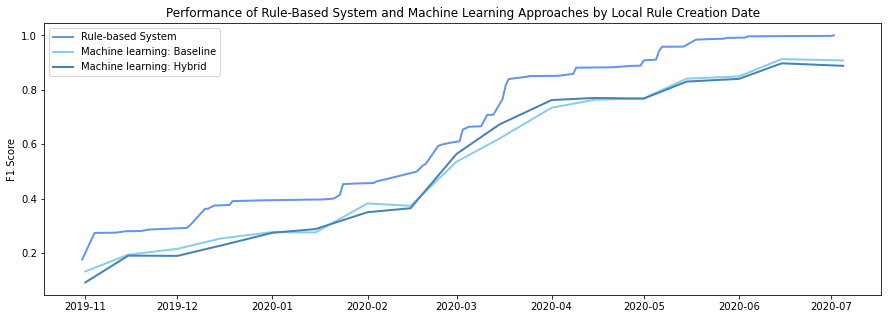

In [50]:
#Set figure size
plt.figure(figsize=(15,5))

#Plot F1 Scores
plt.plot(count['local_rule_creation_date'], y/4724, label= "Rule-based System",color='cornflowerblue',linewidth=2)
plt.plot(results_baseline_df['date_batch'], results_baseline_df['f1_score'], label="Machine learning: Baseline",color='skyblue',linewidth=2)
plt.plot(results_hybrid_df['date_batch'], results_hybrid_df['f1_score'], label="Machine learning: Hybrid",color='steelblue',linewidth=2)

#Format plot
plt.ylabel("F1 Score")
plt.title("Performance of Rule-Based System and Machine Learning Approaches by Local Rule Creation Date")
plt.legend()
plt.show()

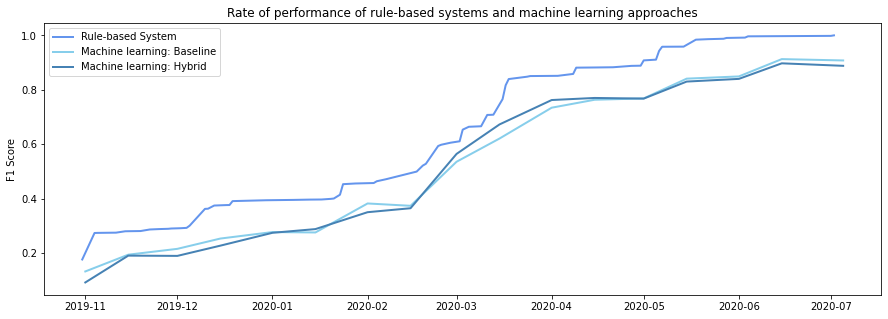

In [25]:
#Set figure size
plt.figure(figsize=(15,5))

#Plot F1 Scores
plt.plot(count['local_rule_creation_date'], y/4724, label= "Rule-based System",color='cornflowerblue',linewidth=2)
plt.plot(results_baseline_df['date_batch'], results_baseline_df['f1_score'], label="Machine learning: Baseline",color='skyblue',linewidth=2)
plt.plot(results_hybrid_df['date_batch'], results_hybrid_df['f1_score'], label="Machine learning: Hybrid",color='steelblue',linewidth=2)

#Format plot
plt.ylabel("F1 Score")
plt.title("Rate of performance of rule-based systems and machine learning approaches")
plt.legend()
plt.show()